# Figure 1. *In vitro* reconstitution of DROSHA processing

A. Experimental scheme of *in vitro* DROSHA processing  
B. Composition of 5' fragments, hairpins, and 3' fragments  
C. Putative DROSHA cleavage sites from processed fragments  
D. Distribution of 3' overhang lengths from hairpin fragments

In [1]:
import time
today = time.strftime('%Y-%m-%d')
name = 'Seungchan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by Seungchan Baek at 2020-10-13.


In [2]:
home = '/casa/bsc/projects/1_DCS/2004_paper_prep/'
utilpath = '/casa/bsc/notebooks/'
%cd $home

/casa/bsc/projects/1_DCS/2004_paper_prep


In [3]:
from __future__ import division
import sys; sys.path.append(utilpath)
from basic import gen_result_dir
from util import *
resultpath = gen_result_dir('results/')
print 'resultpath:', resultpath

resultpath: results/201013/


In [4]:
import pandas as pd
import numpy as np
import re
import gzip
from matplotlib import pyplot as plt
from matplotlib import lines, gridspec
from collections import defaultdict, Counter
%matplotlib inline

In [5]:
PILOT = [ 'pilot-1', 'pilot-2' ]
SET1 = [ 'set1-1', 'set1-2' ]

#### Import supplementary tables

In [6]:
s1 = pd.read_csv('supplementary/201012_s1_pri-info.csv', header=1, index_col=0)
s2 = pd.read_csv('supplementary/201012_s2_pri-construct.csv', header=1, index_col=0)
s4 = pd.read_csv('supplementary/201012_s4_cleavage-product.csv', header=1, index_col=0)
s5 = pd.read_csv('supplementary/201012_s5_pri-structure.csv', header=1, index_col=0)
print 's1:\t%s'%', '.join(list(s1.columns))
print 's2:\t%s'%', '.join(list(s2.columns)[:6])
print 's4:\t%s'%', '.join(list(s4.columns)[:11])
print 's5:\t%s'%', '.join(list(s5.columns)[:10])

s1:	5p mature, 5p sequence, 3p mature, 3p sequence, Note
s2:	Chr, Start, End, Strand, Construct sequence, 100way phyloP scores (pre-miRNA -/+ 100nt)
s4:	rstart, rend, pilot-1, pilot-2, set1-1, set1-2, set2-1, set2-2, set3-1, set3-2, set4-1
s5:	1, 2, 3, 4, 5, 6, 7, 8, 9, 10


In [8]:
redund = s2[s2['Note'].apply(lambda x: str(x).find('Same construct')>=0)].index
s4nored = s4.drop(redund)

In [9]:
def get_pre_position(pri):
    constructseq = s2.loc[pri, 'Construct sequence'].replace('T','U')
    seq5p = s1.loc[pri, '5p sequence']
    seq3p = s1.loc[pri, '3p sequence']
    if seq5p=='n.a.' or constructseq.find(seq5p)==-1:
        prestart = 0
    else:
        prestart = constructseq.find(seq5p)+1
    if seq3p=='n.a.' or constructseq.find(seq3p)==-1:
        preend = 0
    else:
        preend = constructseq.rfind(seq3p)+len(seq3p)
    return prestart, preend

In [10]:
allpris = s1.index
preposition = { pri:get_pre_position(pri) for pri in allpris }
print len(preposition)

1881


In [11]:
mirtrons = [ pri for pri in allpris if s1.loc[pri,'Note'].find('Mirtron')>=0 ]
capped = [ pri for pri in allpris if s1.loc[pri,'Note'].find('Capped miRNA')>=0 ]
drosensitive = [ pri for pri in allpris if s1.loc[pri,'Note'].find('DROSHA KO-sensitive')>=0 ]
fclipdetected = [ pri for pri in allpris if s1.loc[pri,'Note'].find('fCLIP site-determined')>=0 ]
dbmirs = [ pri for pri in allpris if s1.loc[pri,'Note'].find('MirGeneDB')>=0 ]
print len(mirtrons), len(capped), len(drosensitive), len(fclipdetected), len(dbmirs)

239 11 157 281 519


### A. Experimental scheme of *in vitro* DROSHA processing

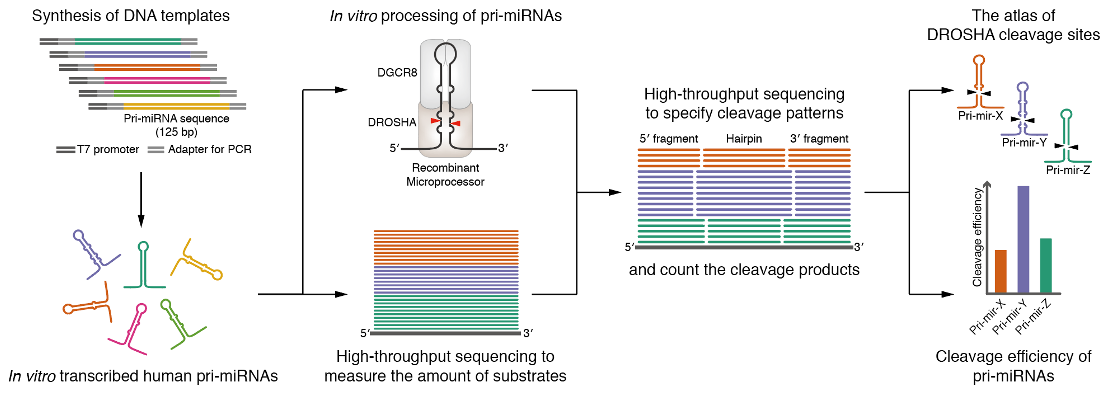

In [11]:
from IPython.display import Image
Image(filename='supplementary/figures/fig1A.png', width=750)

### B. Composition of 5' fragments, hairpins, and 3' fragments
- The pilot library does not have adapter sequences that keep construct sequence intact. That is why some range ("decay" constant) is considered as 5' or 3' end.
- decay = 4

In [12]:
start, mid, end = 1, 63, 125
decay = 4

In [13]:
pitbl = s4nored[['rstart','rend']+PILOT]
pi5f = pitbl[(pitbl['rstart']<=start+decay)&(pitbl['rend']<mid)]
pi3f = pitbl[(pitbl['rstart']>mid)&(pitbl['rend']>=end-decay)]
pih = pitbl[(pitbl['rstart'].apply(lambda x: start+decay<x<mid))&\
             (pitbl['rend'].apply(lambda x: mid<x<end-decay))]

In [14]:
psum5f = pi5f[PILOT].sum().sum()
psumh = pih[PILOT].sum().sum()
psum3f = pi3f[PILOT].sum().sum()
psumel = pitbl[PILOT].sum().sum()-psum5f-psumh-psum3f
print 'pilot 5f:\t%i'%psum5f
print 'pilot hairpin:\t%i'%psumh
print 'pilot 3f:\t%i'%psum3f
print 'pilot else:\t%i'%psumel

pilot 5f:	3423624
pilot hairpin:	41500
pilot 3f:	771421
pilot else:	130743


In [15]:
set1tbl = s4nored[['rstart','rend']+SET1]
s15f = set1tbl[(set1tbl['rstart']==start)&(set1tbl['rend']<mid)]
s13f = set1tbl[(set1tbl['rstart']>mid)&(set1tbl['rend']==end)]
s1h = set1tbl[(set1tbl['rstart']<mid)&(set1tbl['rend']>mid)]

In [16]:
s1sum5f = s15f[SET1].sum().sum()
s1sumh = s1h[SET1].sum().sum()
s1sum3f = s13f[SET1].sum().sum()
s1sumel = set1tbl[SET1].sum().sum()-s1sum5f-s1sumh-s1sum3f
print 'pilot 5f:\t%i'%s1sum5f
print 'pilot hairpin:\t%i'%s1sumh
print 'pilot 3f:\t%i'%s1sum3f
print 'pilot else:\t%i'%s1sumel

pilot 5f:	13357784
pilot hairpin:	7630232
pilot 3f:	10291981
pilot else:	969817


In [17]:
compopilot = [ psum5f, psumh, psum3f, psumel ]
composet1 = [ s1sum5f, s1sumh, s1sum3f, s1sumel ]
#c5, ch, c3, ce = '#7fc97f', '#80b1d3', '#fb8072', '#969696'
c5, ch, c3, ce = '#d95f02', '#7570b3', '#1b9e77', '#969696'
colors = [ c5, ch, c3, ce ]
#colors = [ '#cccccc', '#969696', '#636363', '#252525' ]
labels = [ '5$^\prime$ fragment', 'Hairpin', '3$^\prime$ fragment', 'Others' ]

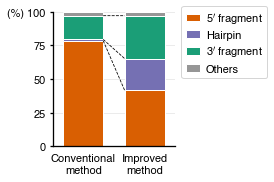

In [18]:
## color version
fig, ax = plt.subplots(1, 1, figsize=(2.2, 2.5))
cum = np.array([0.,0.])
for c1, c2, color, label in zip(compopilot, composet1, colors, labels):
    f1 = c1/sum(compopilot)*100
    f2 = c2/sum(composet1)*100
    ax.bar(range(2), [f1, f2], bottom=cum, width=.65, linewidth=1, edgecolor='white',
           color=color, zorder=2, label=label)
    cum += np.array([f1,f2])
    if label!='Others':
        l = lines.Line2D([.325,.675], cum, linewidth=.8, color='black', linestyle='--')
        l.set_clip_on(False)
        ax.add_line(l)

ax.set_xlim(-.5, 1.5)
ax.set_ylim(0, 101)
ax.set_xticks([0,1])
ax.set_xticklabels(['Conventional\nmethod', 'Improved\nmethod'])
ax.set_yticks([0,25,50,75,100])
ax.set_yticklabels([0,25,50,75,'(%) 100'])
ax.spines['left'].set_bounds(0,100)
ax.tick_params(bottom='off')
ax.legend(loc=(1.05, .5), prop={'size':11}, handlelength=1.3, labelspacing=.4, handletextpad=.5)
ax.yaxis.grid(ls='-', lw=.5)
#fig.savefig(resultpath + '200612_f1b_fragment-composition.pdf')

### C. Putative DROSHA cleavage sites from processed fragments
- Read count cutoff = 30
- Showing window = 5
- lib = 'set1'

In [19]:
rcutoff = 30
window = 5
lib = 'set1'

In [20]:
clvtbl = s4[['rstart','rend']+SET1].copy()
clvtbl['set1'] = clvtbl[['set1-1','set1-2']].sum(axis=1)

In [21]:
start, mid, end = 1, 63, 125
clv5f = clvtbl[(clvtbl['rstart']==start)&(clvtbl['rend']<mid)]
clv3f = clvtbl[(clvtbl['rstart']>mid)&(clvtbl['rend']==end)]
clvh = clvtbl[(clvtbl['rstart'].apply(lambda x: start<x<mid))&
               (clvtbl['rend'].apply(lambda x: mid<x<end))]

In [22]:
def get_frac_5frag(mir):
    sub = clv5f.loc[[mir]].set_index('rend')
    return (sub/sub.sum())

In [23]:
def get_frac_3frag(mir):
    sub = clv3f.loc[[mir]].set_index('rstart')
    return (sub/sub.sum())

In [24]:
def get_frac_hairpin(mir):
    sub = clvh.loc[[mir]].set_index(['rstart','rend'])
    return (sub/sub.sum())

In [25]:
pc = drosensitive
nc = mirtrons

In [26]:
fdata = {}
for mirl, label in zip([pc,nc],['pc','nc']):
    f5s, f3s, fh5s, fh3s = [], [], [], []
    for mir in mirl:
        if min([t.loc[mir,lib].sum() for t in [clv5f,clv3f,clvh]])<rcutoff:
            continue
        ps, pe = preposition[mir]
        if not (ps and pe):
            continue
        f5 = get_frac_5frag(mir).reindex(range(ps-window,ps+window+1)).fillna(0)[lib].tolist()
        f3 = get_frac_3frag(mir).reindex(range(pe-window,pe+window+1)).fillna(0)[lib].tolist()
        fh = pd.pivot_table(get_frac_hairpin(mir).reset_index(),
                           index='rstart', columns='rend')[lib]
        fh5s.append(fh.reindex(range(ps-window,ps+window+1)).fillna(0).T.sum().tolist())
        fh3s.append(fh.T.reindex(range(pe-window,pe+window+1)).fillna(0).T.sum().tolist())
        f5s.append(f5)
        f3s.append(f3)
    f5s = map(np.average, zip(*f5s))
    f3s = map(np.average, zip(*f3s))
    fh5s = map(np.average, zip(*fh5s))
    fh3s = map(np.average, zip(*fh3s))
    fdata[label] = np.array([ f5s,f3s,fh5s,fh3s ])*100

In [27]:
x = np.arange(-5, 6)
y5p, y3p, yh5p, yh3p = fdata['pc']
y5n, y3n, yh5n, yh3n = fdata['nc']
c5, ch, c3 = '#d95f02', '#7570b3', '#1b9e77'
s = 10
lw = 1.8

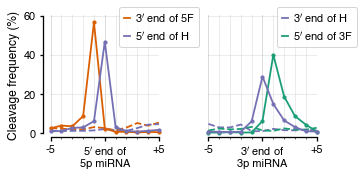

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,2.3))
fig.subplots_adjust(wspace=.3)

ax1.plot(x, y5n, lw=lw, c=c5, ls='--')
ax1.plot(x, yh5n, lw=lw, c=ch, ls='--')
ax1.plot(x, y5p, lw=lw, c=c5, label='3$^\prime$ end of 5F')
ax1.plot(x, yh5p, lw=lw, c=ch, label='5$^\prime$ end of H')
ax1.scatter(x, y5p, s=s, c=c5, zorder=3)
ax1.scatter(x, yh5p, s=s, c=ch, zorder=3)

ax2.plot(x, yh3n, lw=lw, c=ch, ls='--')
ax2.plot(x, y3n, lw=lw, c=c3, ls='--')
ax2.plot(x, yh3p, lw=lw, c=ch, label='3$^\prime$ end of H', zorder=3)
ax2.plot(x, y3p, lw=lw, c=c3, label='5$^\prime$ end of 3F')
ax2.scatter(x, y3p, s=s, c=c3, zorder=3)
ax2.scatter(x, yh3p, s=s, c=ch, zorder=3)

for ax, l in zip([ax1,ax2], [5,3]):
    ax.set_xlim(-5.7, 5.5)
    ax.set_ylim(-2, 62)
    ax.set_xticks([-5,0,5])
    ax.set_xticks(range(-5,6), minor=True)
    ax.set_yticks([0,20,40,60])
    ax.set_xticklabels(['-5','%s$^\prime$ end of\n%sp miRNA'%(l,l),'+5'])
    ax.spines['left'].set_bounds(0, 60)
    ax.spines['bottom'].set_bounds(-5, 5)
    sq = plt.Rectangle((-5.05,-.2), 10.1, 60.4, fc='w'); ax.add_patch(sq)
    ax.grid(lw=.5, ls='-', clip_path=sq)
    ax.grid(lw=.5, ls='-', which='minor', clip_path=sq)  
    ax.legend(handletextpad=.4, handlelength=.6, loc=(.63,.72), prop={'size':11})

    ax1.set_ylabel('Cleavage frequency (%)', fontsize=12)
ax2.spines['left'].set_visible(False)
ax2.set_yticklabels([])
ax2.tick_params(left='off')
#fig.savefig(resultpath + '200612_f1c_cleavage-frequency.pdf')

### D. Distribution of 3' overhang lengths
- Cutoff for hairpin proportion: 0.01

In [29]:
fcutoff = .01

In [30]:
def get_pre_3overhang(pri):
    constseq = s2.loc[pri, 'Construct sequence']
    hpnseq = hpnseqs[pri].replace('U','T')
    hpnstr = get_new_str(pri)
    pres, pree = preposition[pri]
    rels = pres-constseq.find(hpnseq)
    rele = pree-constseq.find(hpnseq)
    loops = hpnstr.find('L')
    loope = hpnstr.rfind('L')
    return count_len(hpnstr[loope+1:rele])-count_len(hpnstr[rels-1:loops])

In [31]:
def get_hpn_3overhang(pri, hs, he):
    preovh3 = get_pre_3overhang(pri)
    pres, pree = preposition[mir]
    return preovh3 + (he-pree) + (hs-pres)

In [32]:
def filter_frac(frac, fcutoff):
    return frac[frac>=fcutoff]

In [33]:
ovh3data = {}
ranges = [ (-100,0), (1,1), (2,2), (3,3), (4,100) ]
for mirl, label in zip([ pc,nc ],[ 'pc','nc' ]):
    ovhs = []
    for mir in mirl:
        if clvh.loc[mir,lib].sum()<rcutoff:
            continue
        h = filter_frac(get_frac_hairpin(mir), fcutoff).reset_index()
        h['3ov'] = h.apply(lambda x: get_hpn_3overhang(mir,x['rstart'],x['rend']),axis=1)
        ovh = [ h[h['3ov'].apply(lambda x: lb<=x<=ub)]['set1'].sum() for (lb,ub) in ranges ]
        ovhs.append(list(np.array(ovh)/sum(ovh)*100))
    ovh3data[label] = map(np.average, zip(*ovhs))

In [34]:
x = np.arange(5)
w = .36
lw = 1
ls = {'pc':'Canonical miRNAs (Kim et al., 2016)', 'nc':'Mirtrons (Ladewig et al., 2012)'}

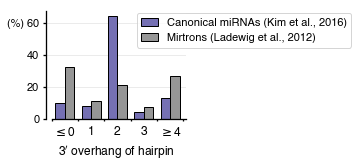

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2))
ax.bar(x-.18, ovh3data['pc'], color=ch, width=w, lw=lw, edgecolor='k', label=ls['pc'], zorder=2)
ax.bar(x+.18, ovh3data['nc'], color=ce, width=w, lw=lw, edgecolor='k', label=ls['nc'], zorder=2)

ax.set_xlim(-.7, 4.6)
ax.set_xticks(x)
ax.set_xticks(np.arange(-1,5)+.5, minor='True')
ax.set_xticklabels(['$\leq$0',1,2,3,'$\geq$4'], fontsize=12)
ax.set_yticks(range(0,61,20))
ax.set_yticklabels([0, 20, 40, '(%) 60'])
ax.set_xlabel('3$^\prime$ overhang of hairpin', fontsize=12)
ax.tick_params(bottom='off')
ax.tick_params(width=1.3, which='minor')
ax.spines['bottom'].set_bounds(-.5,4.6)
ax.yaxis.grid(ls='-', lw=.5)
ax.legend(loc=(.65, .66), prop={'size':11}, handlelength=1.5)
#fig.savefig(resultpath + '200612_f1d_3overhang.pdf')